# Atividade 02: Batch Normalization

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

Uma forma de tornar redes profundas mais fáceis de treinar é utilizar procedimentos de otimização mais sofisticados como, por exemplo, SGD+momento, RMSProp ou Adam. Uma outra estratégia é modificar a arquitetura da rede de forma a torná-la mais fáceil de treinar. Uma ideia nesse sentido é usar *batch normalization* (ou 'normalização em lote') que foi proposta em [1].

A ideia em si é relativamente simples. Métodos de aprendizado de máquina tendem a trabalhar melhor quando sua entrada de dados consiste de características (*features*) não-correlacionadas com média zero e variância unitária. Quando uma rede neural é treinada, pode-se preprocessar os dados antes de utilizá-los no treinamento da rede de forma a explicitamente eliminar qualquer correlação que suas características (*features*) apresentem; isto irá assegurar que a primeira camada da rede receba dados que seguem uma distribuição "adequada". 

Entretanto, mesmo que se preprocessem os dados de entrada, as ativações nas camadas mais profundas da rede provavelmente irão apresentar alguma correlação e não mais terão média nula e/ou variância unitária, uma vez que são produzidas a partir de camadas anteriores da própria rede. Pior ainda, durante o processo de treinamento a distribuição de características (*features*) em cada camada da rede irá se alterar na medida que os pesos de cada camada são atualizados.

Os autores de [1] fizeram a hipótese de que a modificação da distribuição de características (*features*) dentro de redes neurais profundas pode tornar seu treinamento mais difícil. Para contornar esse problema, eles propuseram a inserção na rede de camadas de normalização - denominadas de *batch normalization*. Durante o treinamento, uma camada de *batch normalization* utiliza os dados de um *minibatch* para estimar a média e o desvio padrão de cada característica (*feature*). Então, tais estimativas são usadas para se *centralizar* e normalizar as características(*features*)  dos dados do *minibatch*. Médias móveis de tais estimativas são mantidas durante o treinamento, de modo que, durante o período de teste, elas possam ser usadas para *centralizar* e normalizar as características (*features*) dos dados de teste.

É possível que esta estratégia de normalização possa reduzir a capacidade de representação de uma rede, uma vez que. em alguns casos, talvez fosse ideal para certas camadas ter características cujas médias não são nula ou que não apresentem variâncias unitárias. Dessa forma, as camadas de *batch normalization* devem incluir parâmetros de deslocamento (*shift*) e escala (*scale*) que devem ser aprendidos para cada dimensão independentemente durante o treinamento.

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

In [1]:
# Executa algum código de inicialização desse notebook.
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from dl.classifiers.fc_net import *
from dl.data_utils import get_CIFAR10_data
from dl.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# e descompactado no diretório 'dl/datasets/cifar-10-batches-py'

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Camada de *Batch Normalization*: *Forward pass*

No arquivo `dl/layers.py`, você deverá implementar o *forward pass* relacionado a *batch normalization* na função `batchnorm_forward`.

Uma vez que você termine, você deve executar o seguinte código para testar sua implementação.

In [3]:
# Checa o 'forward pass' durante o treinamento por meio da verificação de médias e variâncias 
# das características tanto antes quanto depois da camada de 'batch normalization'

# Simula o 'forward pass' para uma rede de 2-camadas
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Médias devem estar próximas de zero e desvios padrões próximos de um
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Agora, médias devem estar próximas de 'beta' e desvios padrões próximos de 'gamma'
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [ 1.33226763e-17 -3.94129174e-17  3.29597460e-17]
  std:  [0.99999999 1.         1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]


In [4]:
# Checa o 'forward pass' durante o teste por meio da execução do 'forward pass' em modo de 
# treinamento por várias vezes de forma a obter médias móveis significativas (aquecimento);
# para, em seguida, checar as médias e variâncias das ativações após o 'forward pass' em modo  
# de teste.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

# Realiza "aquecimento" para se obter médias móveis significativas
bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

# Altera para modo de teste de forma a utilizar as médias móveis obtidas anteriormente
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Médias devem estar próximas de zero e desvios padrões próximos de um,
# porém devem apresentar um 'ruído' maior que aquele observado durante o treinamento.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]


## Camada de *Batch Normalization*: *Backward pass*

Agora, você deve implementar o *backward pass* para a camada de *batch normalization* na função `batchnorm_backward`.

Para derivar o *backward pass*, você deverá montar o grafo de computação para a operação de *batch normalization* e utilizar o procedimento de *backpropagation* em cada um dos nós intermediários. Alguns nós intermediários podem ter múltiplas saídas ou ramificações; você deve tomar o cuidado de somar os gradientes de cada uma dessas ramificações durante o *backward pass*.

Assim que você terminar, execute o seguinte código para verificar numericamente sua implementação.

In [6]:
# Verificação do 'backward pass' da camada de 'batch normalization'
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.702926968594948e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


## Camada de *Batch Normalization*: *backward pass* alternativo (opcional, valendo +3 pontos extras)

Durante as aulas, foram apresentados duas diferentes implementações para o 'backward pass' da função sigmoide. Uma estratégia é construir o grafo de computação utilizando operações simples e utilizar o procedimento de *backpropagation* em cada nó intermediário. Uma outra abordagem é obter uma expressão analítica para a derivada de forma direta (usando do ferramental de Cálculo). Para a função sigmoide, é possível se obter uma fórmula muito simples para a derivada e, consequentemente, uma implementação mais eficiente de seu *backward pass*.

Surpreendentemente, você também pode derivar uma expressão simples para ser usada no *backward pass* da camada de *batch normalization* desde que você trabalhe sobre suas derivadas e possíveis simplificações. 

Dado o conjunto de entradas $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, primeiramente se calcula a média $\mu=\frac{1}{N}\sum_{k=1}^N x_k$ e a variância $v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2$. Com $\mu$ e $v$ calculados, pode-se calcular o desvio padrão $\sigma=\sqrt{v+\epsilon}$ e se obter os dados normalizados $Y$ fazendo $y_i=\frac{x_i-\mu}{\sigma}$.

O cerne do problema é obter $\frac{\partial L}{\partial X}$ a partir do gradiente *upstream* $\frac{\partial L}{\partial Y}$. A princípio pode ser desafiador derivar o gradiente em relação ao vetor $X$ a partir do gradiente em relação do vetor $Y$ - por isso, sugere-se que você pense primeiramente sobre as componentes de cada vetor, isto é, $x_i$ and $y_i$ first.

Você deverá obter uma formulação para $\frac{\partial L}{\partial x_i}$ por meio do usa da regra da cadeia de forma a inicialmente se calcular $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ para então juntar essas "peças" no cálculo de$\frac{\partial y_i}{\partial x_i}$. Você deve se assegurar que cada um dos passos intermediários é o mais simples possível.

Depois de fazer isso, você deve implementar sua versão simplificada para o *backward pass* da camada de *batch normalization* na função `batchnorm_backward_alt` e comparar os resultados das duas implementações utilizando o código a seguir. Suas duas implementações devem computar resultados praticamente idênticos, porém a versão alternativa deve ser um pouco mais rápida.

**NOTA:** Esta parta da atividade é inteiramente opcional, mas você ganhará 03 pontos extras caso a conclua corretamente.

In [ ]:
current_time = lambda: int(round(time.clock() * 1000000000))
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = current_time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = current_time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = current_time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

## Redes Completamente Conectadas com *Batch Normalization*

Agora que você possui uma implementação funcional de *batch normalization*, você deverá retornar a implementação da classe `FullyConnectedNet` no arquivo `dl/classifiers/fc_net.py`, de forma a estudar o código que utiliza *batch normalization*.

Para ser mais preciso, quando o *flag* `use_batchnorm` for `True` no construtor da instância, será inserida uma camada de *batch normalization* antes de cada camada não-linear ReLU. As saídas da última camada da rede não serão normalizadas. 

Uma vez que você tenha terminado seu estudo, execute o seguinte código para verificar a implementação.

NOTE: Como antes pode ser útil (para facilitar a codifição) definir camadas auxiliares adicionais de modo similar àquelas definidas no arquivo `dl/layer_utils.py`. Você irá encontrar todo o código (incluindo das camadas adicionais) no arquivo `dl/classifiers/fc_net.py` (o código delas se encontra no final do arquivo).

In [7]:
'''
obs: alterada função 'affine_norm_relu_backward', no arquivo 
     dl/classifiers/fc_net.py para utilização do método 
     'batchnorm_backward' ao invés de 'batchnorm_backward_alt', 
     que não foi implementado.
'''

np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
        
    if reg == 0: 
        print()

Running check with reg =  0
We use batchnorm here
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 3.92e-10
b1 relative error: 2.22e-03
b2 relative error: 2.22e-08
b3 relative error: 4.78e-11
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 2.41e-09

Running check with reg =  3.14
We use batchnorm here
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.29e-06
W3 relative error: 1.11e-08
b1 relative error: 5.55e-09
b2 relative error: 2.22e-08
b3 relative error: 2.64e-10
beta1 relative error: 6.65e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 5.94e-09
gamma2 relative error: 3.72e-09


# *Batch normalization* para Redes Profundas

Execute agora o seguinte cógido para treinar uma rede de 6-camadas em um subconjunto de 1000 amostras de treinamento tanto com quanto sem usar *batch normalization*. 

In [8]:
np.random.seed(231)
# Tentativa de treinamento de uma rede profunda com e sem 'batch normalization'
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

print('Com Batch normalization')
bn_solver = Solver(bn_model
                   , small_data
                   , num_epochs=10
                   , batch_size=50 
                   , update_rule='adam'
                   , optim_config={'learning_rate': 1e-3,}
                   , verbose=True
                   , print_every=500)
bn_solver.train()

print('Sem Batch normalization')
solver = Solver(model
                , small_data
                , num_epochs=10
                , batch_size=50
                , update_rule='adam'
                , optim_config={'learning_rate': 1e-3,}
                , verbose=True
                , print_every=500)
solver.train()

We use batchnorm here
Com Batch normalization
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.132000; val_acc: 0.120000
(Epoch 1 / 10) train acc: 0.332000; val_acc: 0.276000
(Epoch 2 / 10) train acc: 0.424000; val_acc: 0.299000
(Epoch 3 / 10) train acc: 0.473000; val_acc: 0.317000
(Epoch 4 / 10) train acc: 0.520000; val_acc: 0.306000
(Epoch 5 / 10) train acc: 0.561000; val_acc: 0.331000
(Epoch 6 / 10) train acc: 0.630000; val_acc: 0.340000
(Epoch 7 / 10) train acc: 0.681000; val_acc: 0.345000
(Epoch 8 / 10) train acc: 0.729000; val_acc: 0.327000
(Epoch 9 / 10) train acc: 0.769000; val_acc: 0.330000
(Epoch 10 / 10) train acc: 0.789000; val_acc: 0.316000
Sem Batch normalization
(Iteration 1 / 200) loss: 2.302332
(Epoch 0 / 10) train acc: 0.119000; val_acc: 0.121000
(Epoch 1 / 10) train acc: 0.258000; val_acc: 0.223000
(Epoch 2 / 10) train acc: 0.298000; val_acc: 0.267000
(Epoch 3 / 10) train acc: 0.342000; val_acc: 0.268000
(Epoch 4 / 10) train acc: 0.378000; val_acc: 0.29

Execute o seguinte código para visualizar os resultados das duas redes treinadas anteriormente. Você deverá notar que a utilização de *batch normalization* ajuda o procedimento de treinamento da rede convergir mais rapidamente.

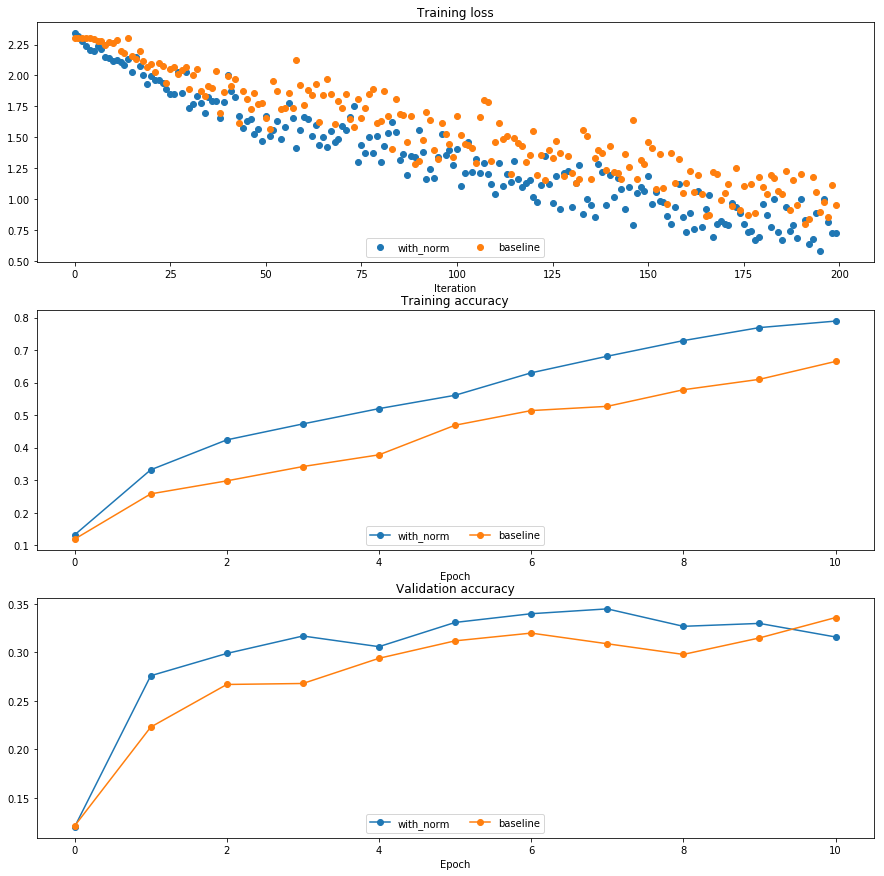

In [9]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# *Batch normalization* e inicialização

Agora, você irá realizar um pequeno experimento para estudar a interação entre *batch normalization* e a inicialização de pesos.

Na próxima célula, você irá encontrar código para realizar treinamento de redes de 8-camadas com e sem *batch normalization* utilizando diferentes escalas para inicialização de pesos. 

Já na célula seguinte, existe código para 'plotar' gráficos sobre: (i) acurácia de treinamento; (ii) acurácia de validação; e (iii) perda durante o treinamento. Tais informações serão exibidas como funções da escala de inicialização de pesos utilizada.

In [10]:
np.random.seed(231)
# Tentativa de treinamento de uma rede 'bem' profunda com e sem 'batch normalization'
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    #print('Com Batch normalization')
    bn_solver = Solver(bn_model
                       , small_data
                       , num_epochs=10
                       , batch_size=50
                       , update_rule='adam'
                       , optim_config={'learning_rate': 1e-3,}
                       , verbose=False
                       , print_every=500
                      )
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    #print('Sem Batch normalization')
    solver = Solver(model
                    , small_data
                    , num_epochs=10
                    , batch_size=50
                    , update_rule='adam'
                    , optim_config={'learning_rate': 1e-3,}
                    , verbose=False
                    , print_every=500
                   )
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
We use batchnorm here
Running weight scale 2 / 20
We use batchnorm here
Running weight scale 3 / 20
We use batchnorm here
Running weight scale 4 / 20
We use batchnorm here
Running weight scale 5 / 20
We use batchnorm here
Running weight scale 6 / 20
We use batchnorm here
Running weight scale 7 / 20
We use batchnorm here
Running weight scale 8 / 20
We use batchnorm here
Running weight scale 9 / 20
We use batchnorm here
Running weight scale 10 / 20
We use batchnorm here
Running weight scale 11 / 20
We use batchnorm here
Running weight scale 12 / 20
We use batchnorm here
Running weight scale 13 / 20
We use batchnorm here
Running weight scale 14 / 20
We use batchnorm here
Running weight scale 15 / 20
We use batchnorm here
Running weight scale 16 / 20
We use batchnorm here
Running weight scale 17 / 20
We use batchnorm here
Running weight scale 18 / 20
We use batchnorm here
Running weight scale 19 / 20
We use batchnorm here
Running weight scale 20 / 20
We use batc

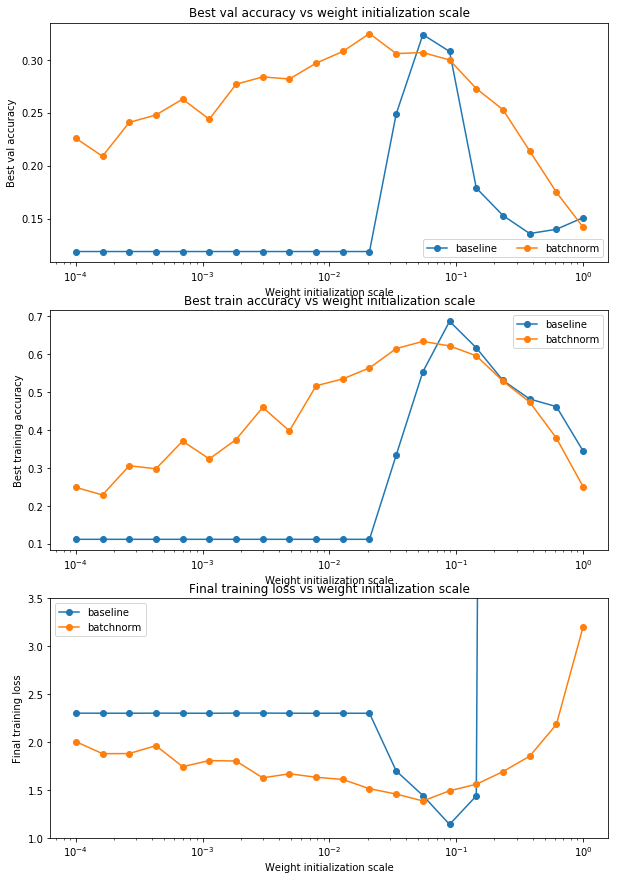

In [11]:
# 'Plota' gráficos dos resultados do experimento com diferentes escalas de iniciação de pesos.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 15)
plt.show()

# Pergunta #01:

Decreva os resultados obtidos pelo experimento acima, procurando fornecer uma razão para os resultados observados.

# Resposta:
O batch normalization permite que mesmo parâmetros "ruins" tenham resultados satisfatórios. Alguns resultados para parâmetros "bons", entretanto, são melhores sem normalização.

# *Batch normalization* e tamanho do *batch*

Você agora irá realizar um pequeno experimento para estudar a interação entre *batch normalization* e o tamanho do *batch*.

No próxima célula, você encontrará código para treinar redes de 6 camadas com e sem uso de *batch normalization* utilizando diferentes tamando de *batch*.

Na célula seguinte, você encontrará código para plotar as acurácias de treinamento e de validação ao longo do tempo.

In [12]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Tentativa de treinamento de uma rede 'bem' profunda com e sem 'batch normalization'
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
We use batchnorm here
Normalization: batch size =  10
We use batchnorm here
Normalization: batch size =  50
We use batchnorm here


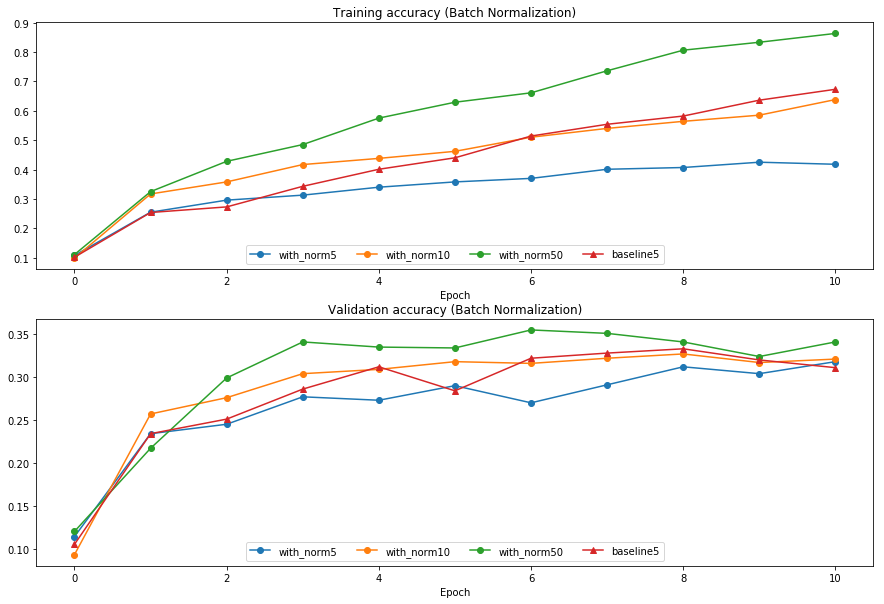

In [13]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Pergunta #02:

Decreva os resultados obtidos pelo experimento acima. O que pode se inferir sobre o relacionamento entre *batch normalization* e o tamanho dos *batches*? Por que esta relação é observada?

# Resposta:
Os melhores resultados foram obtidos com os maiores batches.
Essa relação é observada devido a flutuação de valores ("ruído") existente. Em batches maiores, os ruídos tem menos influência, fazendo com que os resultados sejam mais estáveis. Também pode ser entendido como menor impacto da variância nos batches maiores.